# Examples of use of the BlockProblem class

## Scalar Dahlquist problem

Let's consider the following problem :

$$
\frac{du}{dt} = iu, \quad u_0 = 1, \quad t \in [0, 6\pi],
$$

that we decompose into a block problem of size $N=6$ (which means $\Delta T = \pi$).

We want to use the SDIRK54 time integrator (Runge-Kutta scheme) for each block, using 5 and 2 time steps for the fine and coarse level respectively. Additionally, we want to define for each level an approximate operator using BE with the same number of time steps per block.

We can create and set the associated `BlockProblem` object like this :

In [1]:
import numpy as np
from blockops import BlockProblem

# Create block problem with its fine level operator
prob = BlockProblem(1j, 6*np.pi, nBlocks=6, nPoints=6, scheme='RungeKutta', rkScheme='SDIRK54')
# Set up coarse level :
prob.setCoarseLevel(nPoints=3)
# Set up approximate operator (on coarse and fine level) :
prob.setApprox(scheme='RungeKutta', rkScheme='BE')

**IMPORTANT** : by default, the points are created using a `LOBATTO` type distribution, which means that the time points include the left and right block bounds. RK-type schemes use by default a equidistant points distribution for each blocks, which means that we have to set 6 points per block to have 5 time-steps for the fine level (and similarly for the coarse level).

We can display the (normalized) time points distribution per block like this :

In [2]:
print('Fine time-points :')
print(prob.points)
print('Coarse time-points :')
print(prob.pointsCoarse)

Fine time-points :
[0.  0.2 0.4 0.6 0.8 1. ]
Coarse time-points :
[0.  0.5 1. ]


Eventually, we can obtain the (absolute) time value for each time points in each block like this :

In [3]:
print('Fine time-points for each block :')
print(prob.times)
print('Coarse time-points for each block :')
print(prob.timesCoarse)

Fine time-points for each block :
[[ 0.          0.62831853  1.25663706  1.88495559  2.51327412  3.14159265]
 [ 3.14159265  3.76991118  4.39822972  5.02654825  5.65486678  6.28318531]
 [ 6.28318531  6.91150384  7.53982237  8.1681409   8.79645943  9.42477796]
 [ 9.42477796 10.05309649 10.68141502 11.30973355 11.93805208 12.56637061]
 [12.56637061 13.19468915 13.82300768 14.45132621 15.07964474 15.70796327]
 [15.70796327 16.3362818  16.96460033 17.59291886 18.22123739 18.84955592]]
Coarse time-points for each block :
[[ 0.          1.57079633  3.14159265]
 [ 3.14159265  4.71238898  6.28318531]
 [ 6.28318531  7.85398163  9.42477796]
 [ 9.42477796 10.99557429 12.56637061]
 [12.56637061 14.13716694 15.70796327]
 [15.70796327 17.27875959 18.84955592]]


Now we can compute and plot the solution for each of the associated propagators (only the real part ...), and compare with the exact solution :

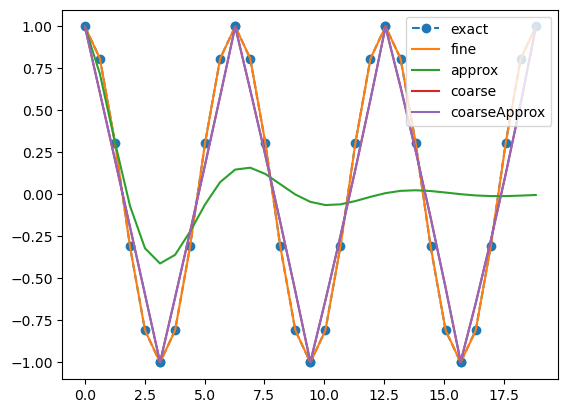

In [4]:
import matplotlib.pyplot as plt

# Get time vector and add t=0
times = prob.times.ravel()

# Compute and plot exact solution
uExact = prob.getSolution('exact').ravel()
plt.plot(times, uExact.real, 'o--', label='exact')

for sType in ['fine', 'approx', 'coarse', 'coarseApprox']:
    u = prob.getSolution(sType).ravel()
    plt.plot(times, u.real, label=sType)
    
plt.legend()

Note that the coarse solution is computed for each of the fine time points, as the coarse propagator is defined like this :

$$
\psi_C = T_C^F \phi_C^{-1} \chi_C T_F^C
$$

and similarly for the coarse approximate operator : restriction and interpolation wrap the application of each propagators on the coarse level.

In order to see what solution the coarse operators produce without interpolation and restriction, we have to work a bit more :

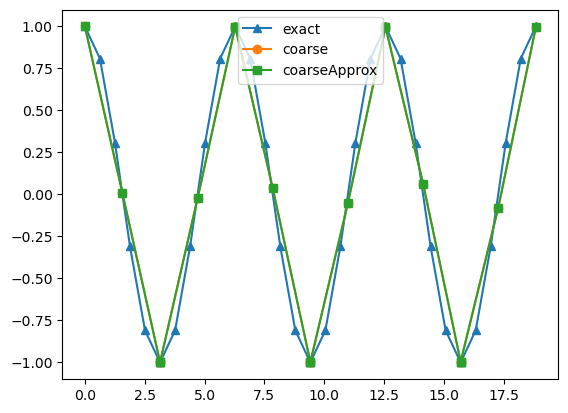

In [5]:
# Restrict initial block vector to the coarse level
u0Coarse = prob.TFtoC(prob.u0)

# Build the coarse level only propagators
coarseProp = prob.phiCoarse**(-1) * prob.chiCoarse
coarseApproxProp = prob.phiCoarseApprox**(-1) * prob.chiCoarse

# Compute sequentially each solution
uCoarse = [u0Coarse]
uCoarseApprox = [u0Coarse]
for n in range(prob.nBlocks):
    uCoarse.append(coarseProp(uCoarse[-1]))
    uCoarseApprox.append(coarseApproxProp(uCoarseApprox[-1]))

# A bit of post-processing
uCoarse = np.array(uCoarse[1:]).ravel()  # Remove initial block vector from solution
uCoarseApprox = np.array(uCoarseApprox[1:]).ravel()
timesCoarse = prob.timesCoarse.ravel()

# Plot solutions
plt.plot(times, uExact.real, '^-', label='exact')
plt.plot(timesCoarse, uCoarse.real, 'o-', label='coarse')
plt.plot(timesCoarse, uCoarseApprox.real, 's-', label='coarseApprox')
plt.legend()
